In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import shutil

from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import zipfile
archieve = zipfile.ZipFile('fall-01-cam1-rgb.zip')
archieve.extractall()

In [ ]:
df_train = pd.read_csv('train.csv')
df_train.rename(columns = {'0':"labels"}, inplace=True)
df_train.loc[159] = 1

In [ ]:
os.makedirs('/content/fall-01-cam1-rgb/train')
for file in os.listdir('fall-01-cam1-rgb'):
  if file != 'train':
    os.replace(f"/content/fall-01-cam1-rgb/{file}", f"/content/fall-01-cam1-rgb/train/{file}")

In [ ]:
index_new = sorted(os.listdir('/content/fall-01-cam1-rgb/train'))
df_train.index = index_new

In [ ]:
dataset_folder = 'fall-01-cam1-rgb'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in sorted(os.listdir(dataset_folder)):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train':
        for file in os.listdir(folder_path):
            if file.endswith('.png'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])

    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (160, 480, 640, 3)
Shape of train labels: (160,)
Shape of stacked test images: (0,)
Shape of test labels: (0,)


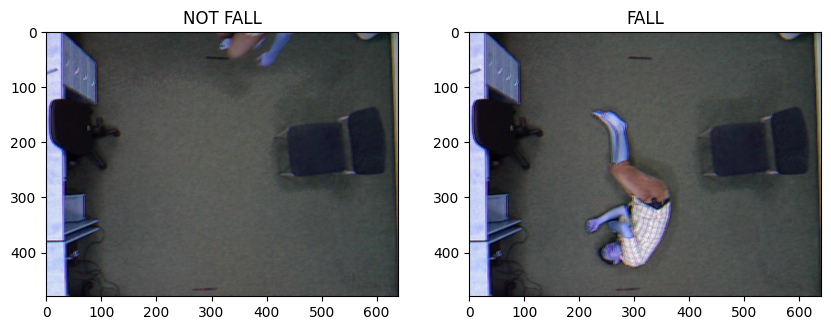

In [ ]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[-1])
axes[0][1].set_title(get_label(train_labels[-1]));

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

In [ ]:
print(X_val.shape)
print(X_train.shape)

(32, 480, 640, 3)
(128, 480, 640, 3)


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.regularizers import l2

In [ ]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

In [ ]:
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

conv1 = conv2d(16, name='convoluton_1')(model_input)
act1 = ReLU(name='activation_1')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(act1)

conv2 = conv2d(16, name='convolution_2')(pool1)
act2 = ReLU(name='activation_2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(act2)

conv3 = conv2d(32, name='convolution_3')(pool2)
act3 = ReLU(name='activation_3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(act3)

conv4 = conv2d(32, name='convolution_4')(pool3)
act4 = ReLU(name='activation_4')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(act4)

conv5 = conv2d(64, name='convolition_5')(pool4)
act5 = ReLU(name='activation_5')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(act5)

conv6 = conv2d(64, name='convolution_6')(pool5)
act6 = ReLU(name='activation_6')(conv6)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(act6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, name='dense1')(flat)
output = Dense(1, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 480, 640, 3)]     0         
                                                                 
 convoluton_1 (Conv2D)       (None, 480, 640, 16)      448       
                                                                 
 activation_1 (ReLU)         (None, 480, 640, 16)      0         
                                                                 
 pooling_1 (MaxPooling2D)    (None, 240, 320, 16)      0         
                                                                 
 convolution_2 (Conv2D)      (None, 240, 320, 16)      2320      
                                                                 
 activation_2 (ReLU)         (None, 240, 320, 16)      0         
                                                                 
 pooling_2 (MaxPooling2D)    (None, 120, 160, 16)      0     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train, epochs = 6, validation_data = (X_val, y_val))

Epoch 1/6
4/4 [==============================] - 43s 10s/step - loss: 30.7130 - accuracy: 0.5859 - val_loss: 4.0707 - val_accuracy: 0.6562
Epoch 2/6
4/4 [==============================] - 28s 7s/step - loss: 2.5994 - accuracy: 0.6562 - val_loss: 2.3180 - val_accuracy: 0.6562
Epoch 3/6
4/4 [==============================] - 25s 6s/step - loss: 1.4979 - accuracy: 0.7344 - val_loss: 0.3590 - val_accuracy: 0.9688
Epoch 4/6
4/4 [==============================] - 25s 6s/step - loss: 0.2117 - accuracy: 0.9688 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 5/6
4/4 [==============================] - 24s 6s/step - loss: 0.0421 - accuracy: 0.9766 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 6/6
4/4 [==============================] - 25s 7s/step - loss: 0.0285 - accuracy: 0.9844 - val_loss: 0.0119 - val_accuracy: 1.0000


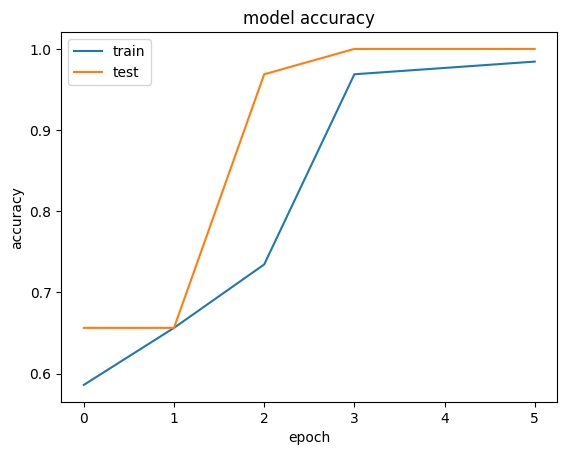

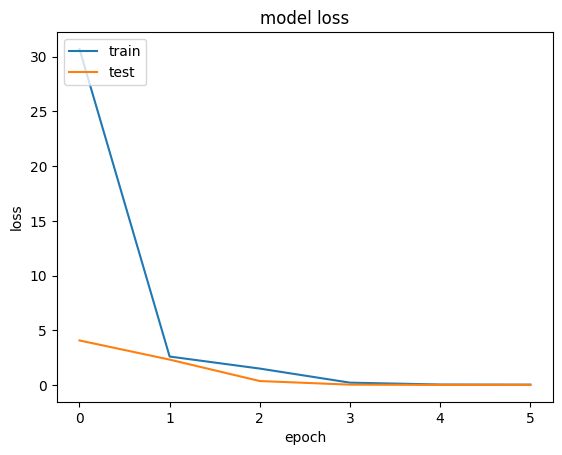

Weights saved.


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('model.h5')
print('Weights saved.')

In [ ]:
predicted_labels = (model.predict(train_images) >= 0.5).astype('int64').flatten()

5/5 [==============================] - 9s 2s/step


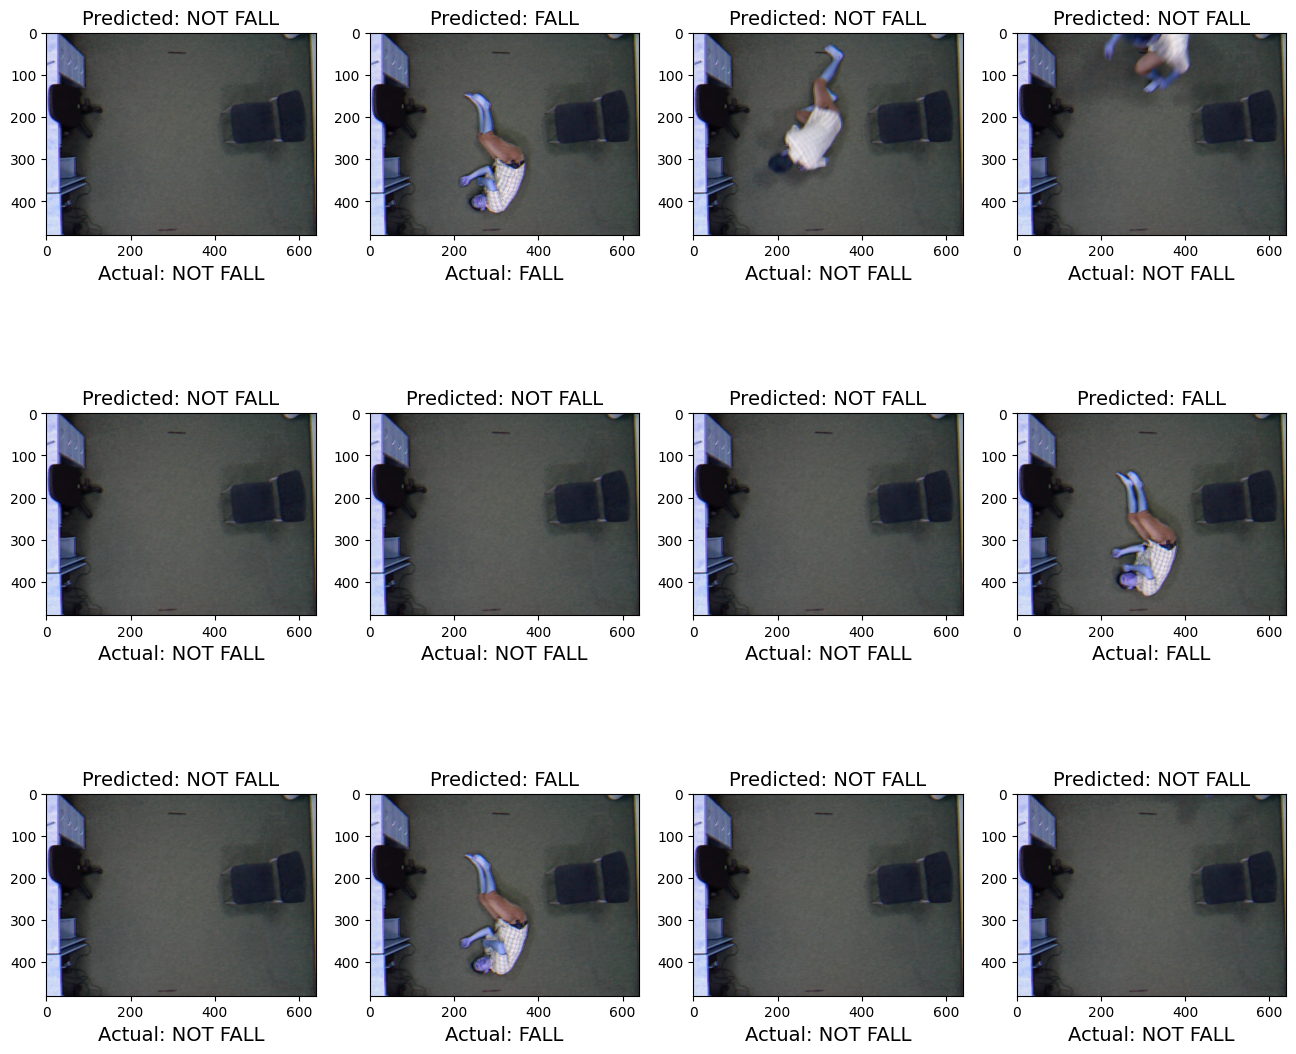

In [ ]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(train_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(train_labels[c])}', fontsize=14)
        c += 14